# README

This Jupyter Notebook file contain the necessary custom codes used in the manuscript titled "*Solution of the FISH-Hi-C paradox for Human Interphase Chromosomes*" to illustrate the methods we proposed to extract the subpopulation information from FISH data. 

**In addition to Python and relevant packages. No other commercial or open-source softwares are used in this study.**

## Software Dependencies

* Python 3.7.3
* Jupyter Notebook (Version 5.0 or newer)
* Python packages: numpy/scipy/pandas/lmfit/matplotlib/xlrd

## How To Use

This notebook describes the procedure used in the study to extract cell subpopulation information from FISH data. The results relevant to this notebook are Fig.4/5/6 in the main text of the manuscript and Fig.2/3/5/6/7 in the Supplementary Information of the manuscript.

## Additional Information

This notebook does not contain the codes to generate the results shown in Fig.1/2/3 in the main text of the manuscript. These results are either theoretical or obtained from simulation which we believe are already fully described in the manuscript.

In [24]:
# First the required packages needed to be imported
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import lmfit
from lmfit import Model
import scipy
from scipy.interpolate import interp1d

import glob

In [3]:
print(np.__version__)
print(matplotlib.__version__)
print(pd.__version__)
print(lmfit.__version__)
print(scipy.__version__)

1.16.2
3.0.3
0.24.2
0.9.13
1.2.1


# Data from Rao et al Cell 2012

## Data preparation

In this study, we use the FISH data [1] to illustrate our methods to extract subpopulation information from the FISH data. In this section, we first prepare our data. The raw FISH data [1] is obtained from the Dropbox depository the authors of [1] set up. Please see this post https://groups.google.com/forum/?utm_medium=email&utm_source=footer#!searchin/3d-genomics/FISH%7Csort:date/3d-genomics/0TI5sz4TyF4/iKCNK3jXAQAJ for more information.

**Instructions**:

* Download the files "FISH_DATA_RH2014_ORIGINAL.xlsx" and "FISH_DATA_RH2014_UPDATED.xlsx" from the link https://www.dropbox.com/sh/ff134nrrs3n3s92/AACvBo0tw8Tp9z0Asei3X97ca?dl=0

* Run the codes in the cell below

In [3]:
# READ RAW FISH XLSX SHEET
peak1 = pd.read_excel('FISH_DATA_RH2014_UPDATED.xlsx', sheet_name=0)
peak2 = pd.read_excel('FISH_DATA_RH2014_UPDATED.xlsx', sheet_name=1)
peak3 = pd.read_excel('FISH_DATA_RH2014_UPDATED.xlsx', sheet_name=2)
peak4 = pd.read_excel('FISH_DATA_RH2014_UPDATED.xlsx', sheet_name=3)

# EXTRACT DATA
peak1_loop = peak1['XYZ-corrected Distance (Loop)'].values
peak1_control = peak1['XYZ-corrected Distance (Control)'].values
peak2_loop = peak2['XYZ-corrected Distance (Loop)'].values
peak2_control = peak2['XYZ-corrected Distance (Control)'].values
peak3_loop = peak3['XYZ-corrected Distance (Loop)'].values
peak3_control = peak3['XYZ-corrected Distance (Control)'].values
peak4_loop = peak4['XYZ-corrected Distance (Loop)'].values
peak4_control = peak4['XYZ-corrected Distance (Control)'].values

If no errors occur, then we have successfully read the data associated with peak1/2/3/4. Now we want to compute the Cumulative Distribution Function from the raw data. The CDFs are used later.

* Execute the codes in the cell below to compute CDF from the raw data and save them to .txt files

After successful execution, you find new files generated in the folder. The following are the file names:

* peak1_loop_cdf.txt
* peak1_control_cdf.txt
* peak2_loop_cdf.txt
* peak2_control_cdf.txt
* peak3_loop_cdf.txt
* peak3_control_cdf.txt
* peak4_loop_cdf.txt
* peak4_control_cdf.txt

In [6]:
# DEFINE FUNCTION TO COMPUTE CUMULATIVE DISTRIBUTION FUNCTION FROM RAW DATA
def compute_cdf_from_data(data, norm_by_mean=False):
    if not norm_by_mean:
        data_sorted = np.sort(data)
    else:
        data_sorted = np.sort(data/np.mean(data))
    data_cdf = np.linspace(0.0,1.0, len(data_sorted))
    return data_sorted, data_cdf

# COMPUTE CDF FROM RAW DATA
peak1_control_sorted, peak1_control_cdf = compute_cdf_from_data(peak1_control)
peak2_control_sorted, peak2_control_cdf = compute_cdf_from_data(peak2_control)
peak3_control_sorted, peak3_control_cdf = compute_cdf_from_data(peak3_control)
peak4_control_sorted, peak4_control_cdf = compute_cdf_from_data(peak4_control)
peak1_loop_sorted, peak1_loop_cdf = compute_cdf_from_data(peak1_loop)
peak2_loop_sorted, peak2_loop_cdf = compute_cdf_from_data(peak2_loop)
peak3_loop_sorted, peak3_loop_cdf = compute_cdf_from_data(peak3_loop)
peak4_loop_sorted, peak4_loop_cdf = compute_cdf_from_data(peak4_loop)

# SAVE CDF TO TXT FILE
np.savetxt('peak1_control_cdf.txt', zip(peak1_control_sorted, peak1_control_cdf))
np.savetxt('peak2_control_cdf.txt', zip(peak2_control_sorted, peak2_control_cdf))
np.savetxt('peak3_control_cdf.txt', zip(peak3_control_sorted, peak3_control_cdf))
np.savetxt('peak4_control_cdf.txt', zip(peak4_control_sorted, peak4_control_cdf))

np.savetxt('peak1_loop_cdf.txt', zip(peak1_loop_sorted, peak1_loop_cdf))
np.savetxt('peak2_loop_cdf.txt', zip(peak2_loop_sorted, peak2_loop_cdf))
np.savetxt('peak3_loop_cdf.txt', zip(peak3_loop_sorted, peak3_loop_cdf))
np.savetxt('peak4_loop_cdf.txt', zip(peak4_loop_sorted, peak4_loop_cdf))

Now we have successfully generate the cumulative distribution function from the raw FISH data. For FISH data whose format are different from the data from Rao [1], it should be trivial to generate CDF accordingly.

The next step is to use our proposed formula to fit FISH data. From the fitting, we are able to extract subpopulation information from the FISH data.

In order to do so, first we need to define the function for our proposed formula which are given by Eq.S5 and Eq.S7 in the Supplementary Information.

In [17]:
# DEFINE FUNCTION EQ.S5 IN THE SUPPLEMENTARY INFORMATION
# NOTE WE USE THE PYTHON PACKAGE SCIPY HERE
def CDF(r, rmean, g, delta):
    B = np.exp(delta * (scipy.special.gammaln((4.0+g)/delta)-scipy.special.gammaln((3.0+g)/delta)))
    result = 1.0 - scipy.special.gammaincc((3.0+g)/delta, B * (r/rmean)**delta)
    return result

# DEFINE FUNCTION EQ.S7 IN THE SUPPLEMENTARY INFORMATION
def CDF_MIX_ANALYTIC(r, eta, rmean1, rmean2, g, delta):
    return eta * CDF(r, rmean1, g, delta) + \
            (1.0-eta) * CDF(r, rmean2, g, delta)

# IT IS ALSO CONVINIENT TO DEFINE FUNCTIONS FOR PDF
def PDF(r, rmean, g, delta):
    A = (delta/rmean) * ((scipy.special.gamma((4.0+g)/delta))**(3.0+g)/(scipy.special.gamma((3.0+g)/delta))**(4.0+g))
    B = (scipy.special.gamma((4.0+g)/delta)/scipy.special.gamma((3.0+g)/delta))**delta
    return A * np.power(r/rmean, 2+g) * np.exp(-B * np.power(r/rmean, delta))


def PDF_MIX_ANALYTIC(r, eta, rmean1, rmean2, g, delta):
    return eta * PDF(r, rmean1, g, delta) + (1.0 - eta) * PDF(r, rmean2, g, delta)

## Results in Fig.S2 and Table.S1 in the Supplementary Information

Once the functions are defined, we can proceed to fit the FISH data assuming two subpopulations. The results generated here are displayed in Fig.S2 and summarized in Table.S1 in the supplementary information.

* Perform the fit to obtain the fitted values of $\eta$,$\langle R_1\rangle$ and $\langle R_2\rangle$
* Perform the Kolmogorov-Smirnov Test on the experimental CDF and theoretical CDF obtained from fitting
* Plot the experimental and fitted CDF and PDF for comparison

In [9]:
# THIS CELL PERFORMS THE FITTING TO OBTAIN THE FITTED VALUES OF \eta, \langle R_1\rangle and \langle R_2\rangle

# CREATE FITTING MODEL, SETTING UP THE PARAMETERS
fit_model = Model(CDF_MIX_ANALYTIC)
fit_model.set_param_hint('eta', value = 0.5, min = 0.0, max = 1.0)
fit_model.set_param_hint('rmean1', value = 1.0, min = 0.0)
fit_model.set_param_hint('rmean2', value = 1.0, min = 0.0)
fit_model.set_param_hint('g', value = 1.0, vary = False)
fit_model.set_param_hint('delta', value = 1.25, vary = False)

# FIT THE DATA
fit_result_peak1_control = fit_model.fit(peak1_control_cdf, r = peak1_control_sorted)
fit_result_peak2_control = fit_model.fit(peak2_control_cdf, r = peak2_control_sorted)
fit_result_peak3_control = fit_model.fit(peak3_control_cdf, r = peak3_control_sorted)
fit_result_peak4_control = fit_model.fit(peak4_control_cdf, r = peak4_control_sorted)
fit_result_peak1_loop = fit_model.fit(peak1_loop_cdf, r = peak1_loop_sorted)
fit_result_peak2_loop = fit_model.fit(peak2_loop_cdf, r = peak2_loop_sorted)
fit_result_peak3_loop = fit_model.fit(peak3_loop_cdf, r = peak3_loop_sorted)
fit_result_peak4_loop = fit_model.fit(peak4_loop_cdf, r = peak4_loop_sorted)

# PRINT OUT THE VALUES OF FITTED PARAMETERS
print "PEAK1-CONTROL:", fit_result_peak1_control.fit_report()
print "PEAK2-CONTROL:", fit_result_peak2_control.fit_report()
print "PEAK3-CONTROL", fit_result_peak3_control.fit_report()
print "PEAK4-CONTROL", fit_result_peak4_control.fit_report()

print "PEAK1-LOOP:", fit_result_peak1_loop.fit_report()
print "PEAK2-LOOP:", fit_result_peak2_loop.fit_report()
print "PEAK3-LOOP:", fit_result_peak3_loop.fit_report()
print "PEAK4-LOOP:", fit_result_peak4_loop.fit_report()

PEAK1-CONTROL: [[Model]]
    Model(CDF_MIX_ANALYTIC)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 101
    # variables        = 3
    chi-square         = 0.01375049
    reduced chi-square = 1.4031e-04
    Akaike info crit   = -893.081921
    Bayesian info crit = -885.236559
[[Variables]]
    eta:     0.55105951 +/- 0.06098041 (11.07%) (init = 0.5)
    rmean1:  0.63121431 +/- 0.01889890 (2.99%) (init = 1)
    rmean2:  1.05627191 +/- 0.04126835 (3.91%) (init = 1)
    g:       1 (fixed)
    delta:   1.25 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(eta, rmean2)    =  0.982
    C(eta, rmean1)    =  0.981
    C(rmean1, rmean2) =  0.936

PEAK2-CONTROL: [[Model]]
    Model(CDF_MIX_ANALYTIC)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 83
    # variables        = 3
    chi-square         = 0.03025490
    reduced chi-square = 3.7819e-04
    Akaike info 

In [16]:
# PERFORM KOLMOGOROV-SMIRNOV TEST

# PEAK1-CONTROL
print "PEAK1-CONTROL K-S TEST:", scipy.stats.kstest(peak1_control_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak1_control.params['eta'].value,\
                                                  fit_result_peak1_control.params['rmean1'].value,\
                                                  fit_result_peak1_control.params['rmean2'].value,\
                                                  fit_result_peak1_control.params['g'].value,
                                                  fit_result_peak1_control.params['delta'].value))

# PEAK1-LOOP
print "PEAK1-LOOP K-S TEST:", scipy.stats.kstest(peak1_loop_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak1_loop.params['eta'].value,\
                                                  fit_result_peak1_loop.params['rmean1'].value,\
                                                  fit_result_peak1_loop.params['rmean2'].value,\
                                                  fit_result_peak1_loop.params['g'].value,
                                                  fit_result_peak1_loop.params['delta'].value))

# PEAK2-CONTROL
print "PEAK2-CONTROL K-S TEST:", scipy.stats.kstest(peak2_control_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak2_control.params['eta'].value,\
                                                  fit_result_peak2_control.params['rmean1'].value,\
                                                  fit_result_peak2_control.params['rmean2'].value,\
                                                  fit_result_peak2_control.params['g'].value,
                                                  fit_result_peak2_control.params['delta'].value))

# PEAK2-LOOP
print "PEAK2-LOOP K-S TEST:", scipy.stats.kstest(peak2_loop_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak2_loop.params['eta'].value,\
                                                  fit_result_peak2_loop.params['rmean1'].value,\
                                                  fit_result_peak2_loop.params['rmean2'].value,\
                                                  fit_result_peak2_loop.params['g'].value,
                                                  fit_result_peak2_loop.params['delta'].value))

# PEAK3-CONTROL
print "PEAK3-CONTROL K-S TEST:", scipy.stats.kstest(peak3_control_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak3_control.params['eta'].value,\
                                                  fit_result_peak3_control.params['rmean1'].value,\
                                                  fit_result_peak3_control.params['rmean2'].value,\
                                                  fit_result_peak3_control.params['g'].value,
                                                  fit_result_peak3_control.params['delta'].value))

# PEAK3-LOOP
print "PEAK3-LOOP K-S TEST:", scipy.stats.kstest(peak3_loop_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak3_loop.params['eta'].value,\
                                                  fit_result_peak3_loop.params['rmean1'].value,\
                                                  fit_result_peak3_loop.params['rmean2'].value,\
                                                  fit_result_peak3_loop.params['g'].value,
                                                  fit_result_peak3_loop.params['delta'].value))

# PEAK4-CONTROL
print "PEAK4-CONTROL K-S TEST:", scipy.stats.kstest(peak4_control_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak4_control.params['eta'].value,\
                                                  fit_result_peak4_control.params['rmean1'].value,\
                                                  fit_result_peak4_control.params['rmean2'].value,\
                                                  fit_result_peak4_control.params['g'].value,
                                                  fit_result_peak4_control.params['delta'].value))

# PEAK4-LOOP
print "PEAK4-LOOP K-S TEST:", scipy.stats.kstest(peak4_loop_sorted, lambda x: CDF_MIX_ANALYTIC(x, fit_result_peak4_loop.params['eta'].value,\
                                                  fit_result_peak4_loop.params['rmean1'].value,\
                                                  fit_result_peak4_loop.params['rmean2'].value,\
                                                  fit_result_peak4_loop.params['g'].value,
                                                  fit_result_peak4_loop.params['delta'].value))

PEAK1-CONTROL K-S TEST: KstestResult(statistic=0.03499764828824625, pvalue=0.999667476229464)
PEAK1-LOOP K-S TEST: KstestResult(statistic=0.061905284981842335, pvalue=0.8336806095861141)
PEAK2-CONTROL K-S TEST: KstestResult(statistic=0.05222027902261278, pvalue=0.9773797573017668)
PEAK2-LOOP K-S TEST: KstestResult(statistic=0.11018923980247365, pvalue=0.2475738583222935)
PEAK3-CONTROL K-S TEST: KstestResult(statistic=0.05610294028663365, pvalue=0.9020469937170518)
PEAK3-LOOP K-S TEST: KstestResult(statistic=0.05071902337536016, pvalue=0.9537254221337955)
PEAK4-CONTROL K-S TEST: KstestResult(statistic=0.06330045864235656, pvalue=0.9881451333372023)
PEAK4-LOOP K-S TEST: KstestResult(statistic=0.06568698260472294, pvalue=0.9822736906757403)


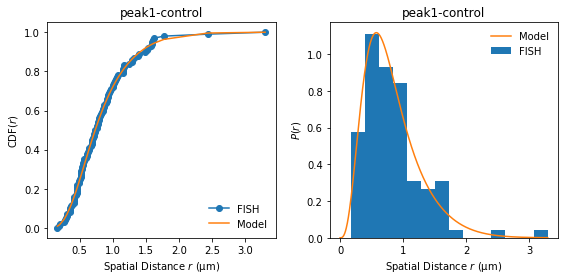

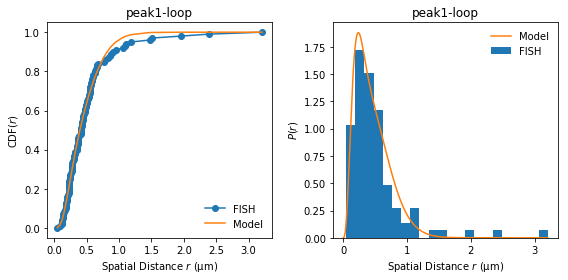

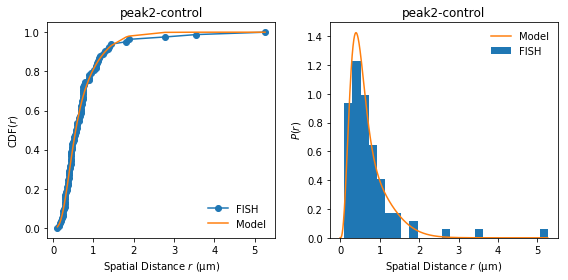

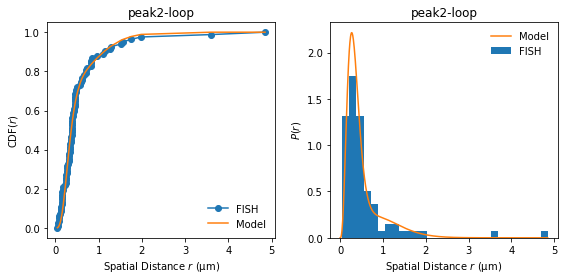

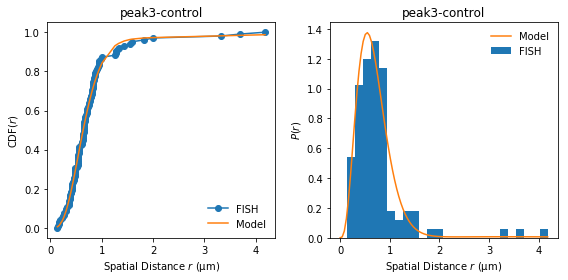

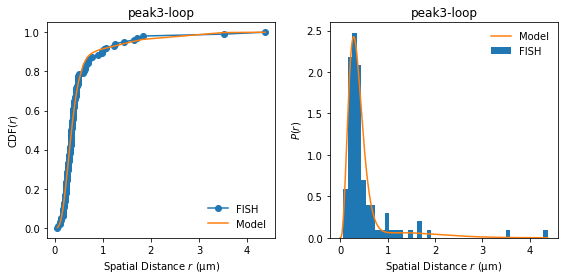

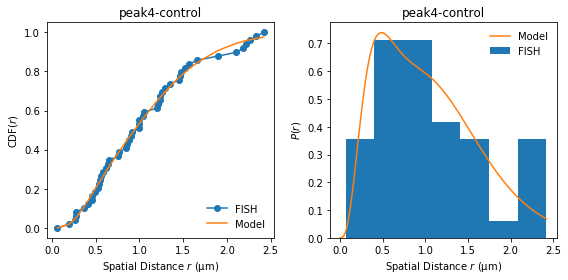

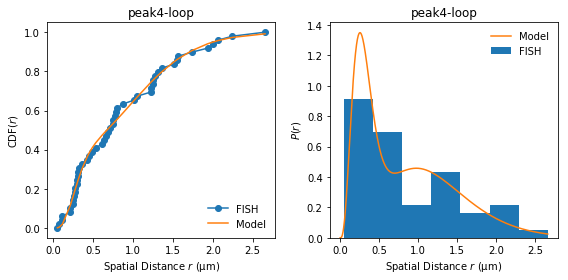

In [15]:
# PLOT EXPERIMENTAL CDF AND PDF AND FITTED CDF AND PDF FOR COMPARISON
# THIS GENERATE THE RESULTS IN FIG.S2 IN THE SUPPLEMENTARY INFORMATION

# PLOT EACH PAIR SEPARATELY
w, h = matplotlib.figure.figaspect(0.5)

# peak1-control
fit_x = np.linspace(0.0,peak1_control_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak1_control_sorted,peak1_control_cdf,marker='o',label='FISH')
ax[0].plot(peak1_control_sorted, fit_result_peak1_control.best_fit,label='Model')
ax[1].hist(peak1_control,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak1_control.params['eta'].value,\
                                                  fit_result_peak1_control.params['rmean1'].value,\
                                                  fit_result_peak1_control.params['rmean2'].value,\
                                                  fit_result_peak1_control.params['g'].value,
                                                  fit_result_peak1_control.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak1-control')
ax[1].set_title('peak1-control')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FIHS_CDF_PDF_peak1_control.pdf')
plt.show()

# peak1-loop
fit_x = np.linspace(0.0,peak1_loop_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak1_loop_sorted,peak1_loop_cdf,marker='o',label='FISH')
ax[0].plot(peak1_loop_sorted, fit_result_peak1_loop.best_fit,label='Model')
ax[1].hist(peak1_loop,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak1_loop.params['eta'].value,\
                                                  fit_result_peak1_loop.params['rmean1'].value,\
                                                  fit_result_peak1_loop.params['rmean2'].value,\
                                                  fit_result_peak1_loop.params['g'].value,
                                                  fit_result_peak1_loop.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak1-loop')
ax[1].set_title('peak1-loop')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak1_loop.pdf')
plt.show()

# peak2-control
fit_x = np.linspace(0.0,peak2_control_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak2_control_sorted,peak2_control_cdf,marker='o',label='FISH')
ax[0].plot(peak2_control_sorted, fit_result_peak2_control.best_fit,label='Model')
ax[1].hist(peak2_control,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak2_control.params['eta'].value,\
                                                  fit_result_peak2_control.params['rmean1'].value,\
                                                  fit_result_peak2_control.params['rmean2'].value,\
                                                  fit_result_peak2_control.params['g'].value,
                                                  fit_result_peak2_control.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak2-control')
ax[1].set_title('peak2-control')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak2_control.pdf')
plt.show()

# peak2-loop
fit_x = np.linspace(0.0,peak2_loop_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak2_loop_sorted, peak2_loop_cdf,marker='o',label='FISH')
ax[0].plot(peak2_loop_sorted, fit_result_peak2_loop.best_fit,label='Model')
ax[1].hist(peak2_loop,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x, PDF_MIX_ANALYTIC(fit_x, fit_result_peak2_loop.params['eta'].value,\
                                                  fit_result_peak2_loop.params['rmean1'].value,\
                                                  fit_result_peak2_loop.params['rmean2'].value,\
                                                  fit_result_peak2_loop.params['g'].value,
                                                  fit_result_peak2_loop.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak2-loop')
ax[1].set_title('peak2-loop')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak2_loop.pdf')
plt.show()

# peak3-control
fit_x = np.linspace(0.0,peak3_control_sorted.max(),100)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak3_control_sorted, peak3_control_cdf,marker='o',label='FISH')
ax[0].plot(peak3_control_sorted, fit_result_peak3_control.best_fit,label='Model')
ax[1].hist(peak3_control,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak3_control.params['eta'].value,\
                                                  fit_result_peak3_control.params['rmean1'].value,\
                                                  fit_result_peak3_control.params['rmean2'].value,\
                                                  fit_result_peak3_control.params['g'].value,
                                                  fit_result_peak3_control.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak3-control')
ax[1].set_title('peak3-control')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak3_control.pdf')
plt.show()

# peak3-loop
fit_x = np.linspace(0.0,peak3_loop_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak3_loop_sorted, peak3_loop_cdf,marker='o',label='FISH')
ax[0].plot(peak3_loop_sorted, fit_result_peak3_loop.best_fit,label='Model')
ax[1].hist(peak3_loop,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak3_loop.params['eta'].value,\
                                                  fit_result_peak3_loop.params['rmean1'].value,\
                                                  fit_result_peak3_loop.params['rmean2'].value,\
                                                  fit_result_peak3_loop.params['g'].value,
                                                  fit_result_peak3_loop.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak3-loop')
ax[1].set_title('peak3-loop')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak3_loop.pdf')
plt.show()

# peak4-control
fit_x = np.linspace(0.0,peak4_control_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak4_control_sorted, peak4_control_cdf,marker='o',label='FISH')
ax[0].plot(peak4_control_sorted, fit_result_peak4_control.best_fit,label='Model')
ax[1].hist(peak4_control,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak4_control.params['eta'].value,\
                                                  fit_result_peak4_control.params['rmean1'].value,\
                                                  fit_result_peak4_control.params['rmean2'].value,\
                                                  fit_result_peak4_control.params['g'].value,
                                                  fit_result_peak4_control.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak4-control')
ax[1].set_title('peak4-control')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak4_control.pdf')
plt.show()

# peak4-loop
fit_x = np.linspace(0.0,peak4_loop_sorted.max(),1000)
fig, ax = plt.subplots(1,2,figsize=(w,h))
ax[0].plot(peak4_loop_sorted, peak4_loop_cdf,marker='o',label='FISH')
ax[0].plot(peak4_loop_sorted, fit_result_peak4_loop.best_fit,label='Model')
ax[1].hist(peak4_loop,bins='auto',density=1,label='FISH')
ax[1].plot(fit_x,  PDF_MIX_ANALYTIC(fit_x, fit_result_peak4_loop.params['eta'].value,\
                                                  fit_result_peak4_loop.params['rmean1'].value,\
                                                  fit_result_peak4_loop.params['rmean2'].value,\
                                                  fit_result_peak4_loop.params['g'].value,
                                                  fit_result_peak4_loop.params['delta'].value),label='Model')

ax[0].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[0].set_ylabel(r'$\mathrm{CDF(}r\mathrm{)}$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\mathrm{\ (\mu m)}$')
ax[1].set_ylabel(r'$P(r)$')
ax[0].legend(loc = 'lower right', frameon=False)
ax[1].legend(loc = 'upper right', frameon=False)

ax[0].set_title('peak4-loop')
ax[1].set_title('peak4-loop')

plt.tight_layout()
# TO EXPORT THE FIGURE, PLEASE UNCOMMENT THE FOLLOWING LINE 
#plt.savefig('FISH_CDF_PDF_peak4_loop.pdf')
plt.show()

## Results in Fig.4 in the main text and Fig.S3 in the Supplementary Information

First we produce the Fig.4a in the main text. 

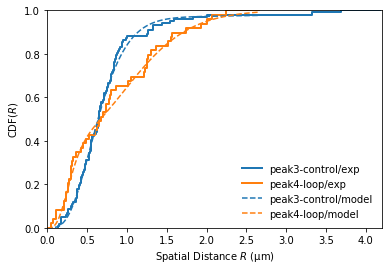

In [17]:
# PRODUCE THE FIG.4A OF THE PAPER
fitx= np.linspace(0.0,5.0,1000)

fig, ax = plt.subplots()
ax.step(peak3_control_sorted, peak3_control_cdf,c='#1f77b4',linewidth=2,label='peak3-control/exp')
ax.step(peak4_loop_sorted, peak4_loop_cdf,c='#ff7f0e',linewidth=2,label='peak4-loop/exp')

#ax.plot(peak3_control_sorted, fit_result_peak3_control.best_fit,c='#1f77b4',label='peak3-control/model')
ax.plot(fit_x,  CDF_MIX_ANALYTIC(fit_x, fit_result_peak3_control.params['eta'].value,\
                                                  fit_result_peak3_control.params['rmean1'].value,\
                                                  fit_result_peak3_control.params['rmean2'].value,\
                                                  fit_result_peak3_control.params['g'].value,
                                                  fit_result_peak3_control.params['delta'].value),c='#1f77b4',\
        label='peak3-control/model',linestyle='--')

#ax.plot(peak4_loop_sorted, fit_result_peak4_loop.best_fit,c='#ff7f0e',label='peak4-loop/model')
ax.plot(fit_x,  CDF_MIX_ANALYTIC(fit_x, fit_result_peak4_loop.params['eta'].value,\
                                                  fit_result_peak4_loop.params['rmean1'].value,\
                                                  fit_result_peak4_loop.params['rmean2'].value,\
                                                  fit_result_peak4_loop.params['g'].value,
                                                  fit_result_peak4_loop.params['delta'].value),c='#ff7f0e',\
        label='peak4-loop/model',linestyle='--')

ax.set_xlim([0.0,4.2])
ax.set_ylim([0.0,1.0])

ax.set_xlabel(r'$\mathrm{Spatial\ Distance\ }R\mathrm{\ (\mu m)}$')
ax.set_ylabel(r'$\mathrm{CDF}(R)$')

plt.legend(loc='lower right',frameon=False)
#plt.savefig('FIG4A.PDF')
plt.show()

In the Fig.4b, we show the comparison between the experimental measured contact probability of eight pairs of loci and the predicted values from the theory. This requires:

* Experimental values of contact probabilities. This is obtained from Hi-C experiment from the same work of FISH data [1].
* Compute the contact probability using the parameters obtained from the fitting CDF in the previous steps

Execute the following cells to perform the analysis

In [19]:
# CONTACT PROB INFERRED FROM MODEL COMPARED WITH HI-C DATA

# RAW HI-C CONTACT DATA (NORMALIZED)
peak1_loop_contact = 1560.11
peak1_control_contact = 79.1796
peak2_loop_contact = 1127.48
peak2_control_contact = 154.962
peak3_loop_contact = 1493.61
peak3_control_contact = 104.328
peak4_loop_contact = 624.282
peak4_control_contact = 19.7234

# DEFINE FUNCTION TO COMPUTE THEORETICAL CONTACT PROBABILITY
def contact_prob_theory(rmean, rc):
    return scipy.special.erf(2.0 * rc/(np.sqrt(np.pi) * rmean)) - (4.0/np.pi) * (rc/rmean) * np.exp(-4.0 * rc**2.0/(np.pi * (rmean**2.0)))

def estimate_contact_prob_rouse(fit_result, rc):
    return fit_result.params['eta'].value * contact_prob_theory(fit_result.params['rmean1'].value, rc) + \
            (1.0 - fit_result.params['eta'].value) * contact_prob_theory(fit_result.params['rmean2'].value, rc)

def estimate_contact_prob_general(fit_result, rc):
    eta = fit_result.params['eta'].value
    rmean1 = fit_result.params['rmean1'].value
    rmean2 = fit_result.params['rmean2'].value
    g = fit_result.params['g'].value
    delta = fit_result.params['delta'].value
    
    return CDF_MIX_ANALYTIC(rc, eta, rmean1, rmean2, g, delta)

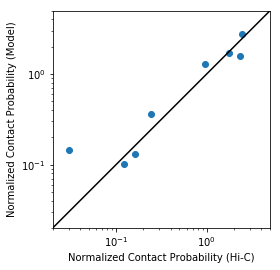

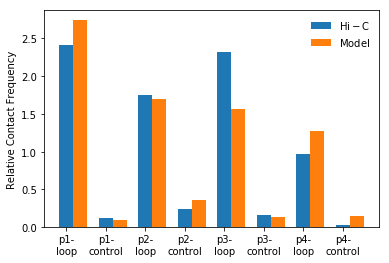

In [21]:
y_exp = np.array([peak1_loop_contact, peak1_control_contact, peak2_loop_contact, peak2_control_contact, \
                  peak3_loop_contact, peak3_control_contact, peak4_loop_contact, peak4_control_contact])\
                /np.mean(np.array([peak1_loop_contact, peak1_control_contact, peak2_loop_contact, peak2_control_contact, \
                  peak3_loop_contact, peak3_control_contact, peak4_loop_contact, peak4_control_contact]))


rc = 0.01

peak1_control_contact_predict = estimate_contact_prob_general(fit_result_peak1_control, rc)
peak1_loop_contact_predict = estimate_contact_prob_general(fit_result_peak1_loop, rc)
peak2_control_contact_predict = estimate_contact_prob_general(fit_result_peak2_control, rc)
peak2_loop_contact_predict = estimate_contact_prob_general(fit_result_peak2_loop, rc)
peak3_control_contact_predict = estimate_contact_prob_general(fit_result_peak3_control, rc)
peak3_loop_contact_predict = estimate_contact_prob_general(fit_result_peak3_loop, rc)
peak4_control_contact_predict = estimate_contact_prob_general(fit_result_peak4_control, rc)
peak4_loop_contact_predict = estimate_contact_prob_general(fit_result_peak4_loop, rc)

y_predict = np.array([peak1_loop_contact_predict,peak1_control_contact_predict,peak2_loop_contact_predict,\
                      peak2_control_contact_predict,peak3_loop_contact_predict,peak3_control_contact_predict,\
                      peak4_loop_contact_predict,peak4_control_contact_predict])/\
    np.mean(np.array([peak1_loop_contact_predict,peak1_control_contact_predict,peak2_loop_contact_predict,\
                      peak2_control_contact_predict,peak3_loop_contact_predict,peak3_control_contact_predict,\
                      peak4_loop_contact_predict,peak4_control_contact_predict]))
    
fig, ax = plt.subplots()
ax.scatter(y_exp, y_predict)
ax.plot([0.01,10],[0.01,10],c='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
ax.set_xlabel('Normalized Contact Probability (Hi-C)')
ax.set_ylabel('Normalized Contact Probability (Model)')
ax.set_xlim([0.02,5])
ax.set_ylim([0.02,5])
plt.show()

x = np.linspace(1,100,8)
xx = x[np.array([1,0,3,2,5,4,7,6])]
fig, ax = plt.subplots()
ax.bar(x,y_exp,width=5,label=r'$\mathrm{Hi-C}$')
ax.bar(5+x,y_predict,width=5,label=r'$\mathrm{Model}$')
ax.set_xticks(x)
ax.set_xticklabels(['p1-\nloop','p1-\ncontrol','p2-\nloop','p2-\ncontrol',\
                   'p3-\nloop','p3-\ncontrol','p4-\nloop','p4-\ncontrol'])
ax.set_ylabel('Relative Contact Frequency')
plt.legend(loc='upper right',frameon=False)
#plt.savefig('hic_infer_contact_prob_bars.pdf', dpi = 300)
plt.show()

Now we generate the results shown in Fig.S3 in the Supplementary Information

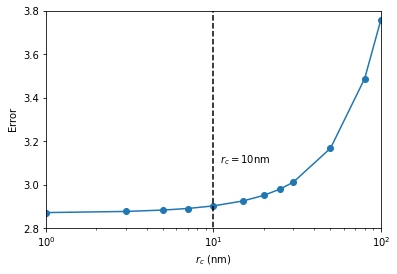

In [22]:
err = []
rc_array = np.array([0.001,0.003,0.005,0.007,0.01,0.015,0.02,0.025,0.03,0.05,0.08,0.1])
for rc in rc_array:
    peak1_control_contact_predict = estimate_contact_prob_general(fit_result_peak1_control, rc)
    peak1_loop_contact_predict = estimate_contact_prob_general(fit_result_peak1_loop, rc)
    peak2_control_contact_predict = estimate_contact_prob_general(fit_result_peak2_control, rc)
    peak2_loop_contact_predict = estimate_contact_prob_general(fit_result_peak2_loop, rc)
    peak3_control_contact_predict = estimate_contact_prob_general(fit_result_peak3_control, rc)
    peak3_loop_contact_predict = estimate_contact_prob_general(fit_result_peak3_loop, rc)
    peak4_control_contact_predict = estimate_contact_prob_general(fit_result_peak4_control, rc)
    peak4_loop_contact_predict = estimate_contact_prob_general(fit_result_peak4_loop, rc)
    
    # predict contact probability, normalized by its mean
    y_predict = np.array([peak1_loop_contact_predict,peak1_control_contact_predict,peak2_loop_contact_predict,\
                      peak2_control_contact_predict,peak3_loop_contact_predict,peak3_control_contact_predict,\
                      peak4_loop_contact_predict,peak4_control_contact_predict])/\
    np.mean(np.array([peak1_loop_contact_predict,peak1_control_contact_predict,peak2_loop_contact_predict,\
                      peak2_control_contact_predict,peak3_loop_contact_predict,peak3_control_contact_predict,\
                      peak4_loop_contact_predict,peak4_control_contact_predict]))
    
    err.append(np.sum(np.power(np.log(y_predict) - np.log(y_exp), 2.0)))
    
fig, ax = plt.subplots()
ax.plot(1000*rc_array, err,marker='o')
ax.plot([10,10],[0,10.0],c='k',linestyle='--')
ax.text(0.52,0.3,r'$r_{c}=10\mathrm{nm}$',transform=ax.transAxes)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1,100])
ax.set_ylim([2.8,3.8])

ax.set_xlabel(r'$r_{c}\mathrm{\ (nm)}$')
ax.set_ylabel(r'$\mathrm{Error}$')
#plt.savefig('error_cutoff_function.pdf', dpi = 300)
plt.show()

## Reproduce Table.S2 in the Supplementary Information

In the following codes, we quantify the goodness of fitting for different parameter sets of $g$ and $\delta$.

## $g=1$,$\delta=5/4$

In [26]:
fit_model = Model(CDF_MIX_ANALYTIC)
fit_model.set_param_hint('eta', value = 0.5, min = 0.0, max = 1.0)
fit_model.set_param_hint('rmean1', value = 1.0, min = 0.0)
fit_model.set_param_hint('rmean2', value = 1.0, min = 0.0)
fit_model.set_param_hint('g', value = 1.0, vary = False)
fit_model.set_param_hint('delta', value = 1.25, vary = False)

# FIT THE DATA USING TWO-SUBPOPULATION FORMULA
fit_result_peak1_control = fit_model.fit(peak1_control_cdf, r = peak1_control_sorted)
fit_result_peak2_control = fit_model.fit(peak2_control_cdf, r = peak2_control_sorted)
fit_result_peak3_control = fit_model.fit(peak3_control_cdf, r = peak3_control_sorted)
fit_result_peak4_control = fit_model.fit(peak4_control_cdf, r = peak4_control_sorted)
fit_result_peak1_loop = fit_model.fit(peak1_loop_cdf, r = peak1_loop_sorted)
fit_result_peak2_loop = fit_model.fit(peak2_loop_cdf, r = peak2_loop_sorted)
fit_result_peak3_loop = fit_model.fit(peak3_loop_cdf, r = peak3_loop_sorted)
fit_result_peak4_loop = fit_model.fit(peak4_loop_cdf, r = peak4_loop_sorted)

# COMPUTE RESIDUE ERRORprint
rss_g1_delta54 = np.mean(np.power(peak1_control_cdf - fit_result_peak1_control.best_fit, 2.0))+\
np.mean(np.power(peak1_loop_cdf - fit_result_peak1_loop.best_fit, 2.0))+\
np.mean(np.power(peak2_control_cdf - fit_result_peak2_control.best_fit, 2.0))+\
np.mean(np.power(peak2_loop_cdf - fit_result_peak2_loop.best_fit, 2.0))+\
np.mean(np.power(peak3_control_cdf - fit_result_peak3_control.best_fit, 2.0))+\
np.mean(np.power(peak3_loop_cdf - fit_result_peak3_loop.best_fit, 2.0))+\
np.mean(np.power(peak4_control_cdf - fit_result_peak4_control.best_fit, 2.0))+\
np.mean(np.power(peak4_loop_cdf - fit_result_peak4_loop.best_fit, 2.0))

print "Residue Error: ", rss_g1_delta54

Residue Error:  0.003919357605255368


## $g=0$,$\delta=2$

In [28]:
fit_model = Model(CDF_MIX_ANALYTIC)
fit_model.set_param_hint('eta', value = 0.5, min = 0.0, max = 1.0)
fit_model.set_param_hint('rmean1', value = 1.0, min = 0.0)
fit_model.set_param_hint('rmean2', value = 1.0, min = 0.0)
fit_model.set_param_hint('g', value = 0.0, vary = False)
fit_model.set_param_hint('delta', value = 2.0, vary = False)

# FIT THE DATA USING TWO-SUBPOPULATION FORMULA
fit_result_peak1_control = fit_model.fit(peak1_control_cdf, r = peak1_control_sorted)
fit_result_peak2_control = fit_model.fit(peak2_control_cdf, r = peak2_control_sorted)
fit_result_peak3_control = fit_model.fit(peak3_control_cdf, r = peak3_control_sorted)
fit_result_peak4_control = fit_model.fit(peak4_control_cdf, r = peak4_control_sorted)
fit_result_peak1_loop = fit_model.fit(peak1_loop_cdf, r = peak1_loop_sorted)
fit_result_peak2_loop = fit_model.fit(peak2_loop_cdf, r = peak2_loop_sorted)
fit_result_peak3_loop = fit_model.fit(peak3_loop_cdf, r = peak3_loop_sorted)
fit_result_peak4_loop = fit_model.fit(peak4_loop_cdf, r = peak4_loop_sorted)


rss_g0_delta2 = np.mean(np.power(peak1_control_cdf - fit_result_peak1_control.best_fit, 2.0))+\
np.mean(np.power(peak1_loop_cdf - fit_result_peak1_loop.best_fit, 2.0))+\
np.mean(np.power(peak2_control_cdf - fit_result_peak2_control.best_fit, 2.0))+\
np.mean(np.power(peak2_loop_cdf - fit_result_peak2_loop.best_fit, 2.0))+\
np.mean(np.power(peak3_control_cdf - fit_result_peak3_control.best_fit, 2.0))+\
np.mean(np.power(peak3_loop_cdf - fit_result_peak3_loop.best_fit, 2.0))+\
np.mean(np.power(peak4_control_cdf - fit_result_peak4_control.best_fit, 2.0))+\
np.mean(np.power(peak4_loop_cdf - fit_result_peak4_loop.best_fit, 2.0))

print "Residue Error: ", rss_g0_delta2

Residue Error:  0.003968532197698943


## $g=0.71$,$\delta=5/2$

In [29]:
fit_model = Model(CDF_MIX_ANALYTIC)
fit_model.set_param_hint('eta', value = 0.5, min = 0.0, max = 1.0)
fit_model.set_param_hint('rmean1', value = 1.0, min = 0.0)
fit_model.set_param_hint('rmean2', value = 1.0, min = 0.0)
fit_model.set_param_hint('g', value = 0.71, vary = False)
fit_model.set_param_hint('delta', value = 2.5, vary = False)

# FIT THE DATA USING TWO-SUBPOPULATION FORMULA
fit_result_peak1_control = fit_model.fit(peak1_control_cdf, r = peak1_control_sorted)
fit_result_peak2_control = fit_model.fit(peak2_control_cdf, r = peak2_control_sorted)
fit_result_peak3_control = fit_model.fit(peak3_control_cdf, r = peak3_control_sorted)
fit_result_peak4_control = fit_model.fit(peak4_control_cdf, r = peak4_control_sorted)
fit_result_peak1_loop = fit_model.fit(peak1_loop_cdf, r = peak1_loop_sorted)
fit_result_peak2_loop = fit_model.fit(peak2_loop_cdf, r = peak2_loop_sorted)
fit_result_peak3_loop = fit_model.fit(peak3_loop_cdf, r = peak3_loop_sorted)
fit_result_peak4_loop = fit_model.fit(peak4_loop_cdf, r = peak4_loop_sorted)

rss_g071_delta52 = np.mean(np.power(peak1_control_cdf - fit_result_peak1_control.best_fit, 2.0))+\
np.mean(np.power(peak1_loop_cdf - fit_result_peak1_loop.best_fit, 2.0))+\
np.mean(np.power(peak2_control_cdf - fit_result_peak2_control.best_fit, 2.0))+\
np.mean(np.power(peak2_loop_cdf - fit_result_peak2_loop.best_fit, 2.0))+\
np.mean(np.power(peak3_control_cdf - fit_result_peak3_control.best_fit, 2.0))+\
np.mean(np.power(peak3_loop_cdf - fit_result_peak3_loop.best_fit, 2.0))+\
np.mean(np.power(peak4_control_cdf - fit_result_peak4_control.best_fit, 2.0))+\
np.mean(np.power(peak4_loop_cdf - fit_result_peak4_loop.best_fit, 2.0))

print "Residue Error: ", rss_g071_delta52

Residue Error:  0.007617802211674503


## Fit the FISH data using single population (homogeneous). Results in Table.S3 and Fig.5 in the Supplementary Information

In the following codes, we demonstrate how to fit the FISH data assuming only single population. Note that the free parameters we want to fit is $g$ and $\delta$ instead. However due to numerical instability, we need to use a trick. Note that $(3+g)/\delta\geq0.0$ (see Eq.S7 in the Supplementary Information), we create another parameter $\omega$ with minimum possible value of $0$ and fix $\delta=(3+g)/\omega$

Due to numerical issue, it is also convenient to fit the normalized CDF instead of raw CDF. Since the normalized CDF is normalized by its mean, thus the x-axis is contrained to a small range. Note that we can do this only because we assume single population since it normalized by mean is only meaningful when there is only one subpopulation.

In [30]:
# CREATE FITTING MODEL, SETTING UP THE PARAMETERS
# (3+g)/delta > 0.0
# create third parameters: omega = (3+g)/delta, to implement the inequality
fit_model = Model(CDF)
fit_model.set_param_hint('rmean', value = 1.0, vary = False)
fit_model.set_param_hint('g', value = 0.0, vary = True)
fit_model.set_param_hint('omega', value = 1.5, min = 0.0, vary = True)
fit_model.set_param_hint('delta', expr='(3.0+g)/omega')

# COMPUTE NORMALIZED BY MEAN CDF FROM RAW DATA
peak1_control_normed_sorted, peak1_control_normed_cdf = compute_cdf_from_data(peak1_control, norm_by_mean = True)
peak2_control_normed_sorted, peak2_control_normed_cdf = compute_cdf_from_data(peak2_control, norm_by_mean = True)
peak3_control_normed_sorted, peak3_control_normed_cdf = compute_cdf_from_data(peak3_control, norm_by_mean = True)
peak4_control_normed_sorted, peak4_control_normed_cdf = compute_cdf_from_data(peak4_control, norm_by_mean = True)
peak1_loop_normed_sorted, peak1_loop_normed_cdf = compute_cdf_from_data(peak1_loop, norm_by_mean = True)
peak2_loop_normed_sorted, peak2_loop_normed_cdf = compute_cdf_from_data(peak2_loop, norm_by_mean = True)
peak3_loop_normed_sorted, peak3_loop_normed_cdf = compute_cdf_from_data(peak3_loop, norm_by_mean = True)
peak4_loop_normed_sorted, peak4_loop_normed_cdf = compute_cdf_from_data(peak4_loop, norm_by_mean = True)

In [31]:
# FIT THE DATA
fit_result_peak1_normed_control = fit_model.fit(peak1_control_normed_cdf, r = peak1_control_normed_sorted)
fit_result_peak2_normed_control = fit_model.fit(peak2_control_normed_cdf, r = peak2_control_normed_sorted)
fit_result_peak3_normed_control = fit_model.fit(peak3_control_normed_cdf, r = peak3_control_normed_sorted)
fit_result_peak4_normed_control = fit_model.fit(peak4_control_normed_cdf, r = peak4_control_normed_sorted)
fit_result_peak1_normed_loop = fit_model.fit(peak1_loop_normed_cdf, r = peak1_loop_normed_sorted)
fit_result_peak2_normed_loop = fit_model.fit(peak2_loop_normed_cdf, r = peak2_loop_normed_sorted)
fit_result_peak3_normed_loop = fit_model.fit(peak3_loop_normed_cdf, r = peak3_loop_normed_sorted)
fit_result_peak4_normed_loop = fit_model.fit(peak4_loop_normed_cdf, r = peak4_loop_normed_sorted)

Print out the results from fitting. The results are summarized in Table.S3 in the Supplementary Information

In [32]:
# PRINT OUT THE VALUES OF FITTED PARAMETERS
print "PEAK1-CONTROL:", fit_result_peak1_normed_control.fit_report()
print "PEAK2-CONTROL:", fit_result_peak2_normed_control.fit_report()
print "PEAK3-CONTROL", fit_result_peak3_normed_control.fit_report()
print "PEAK4-CONTROL", fit_result_peak4_normed_control.fit_report()

print "PEAK1-LOOP:", fit_result_peak1_normed_loop.fit_report()
print "PEAK2-LOOP:", fit_result_peak2_normed_loop.fit_report()
print "PEAK3-LOOP:", fit_result_peak3_normed_loop.fit_report()
print "PEAK4-LOOP:", fit_result_peak4_normed_loop.fit_report()

PEAK1-CONTROL: [[Model]]
    Model(CDF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 101
    # variables        = 2
    chi-square         = 0.01330407
    reduced chi-square = 1.3438e-04
    Akaike info crit   = -898.415353
    Bayesian info crit = -893.185112
[[Variables]]
    rmean:  1 (fixed)
    g:      8.67917776 +/- 2.11766072 (24.40%) (init = 0)
    delta:  0.29557405 +/- 0.05240612 (17.73%) == '(3.0+g)/omega'
    omega:  39.5135422 +/- 14.1646807 (35.85%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(g, omega) =  1.000

PEAK2-CONTROL: [[Model]]
    Model(CDF)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 83
    # variables        = 2
    chi-square         = 0.09665853
    reduced chi-square = 0.00119332
    Akaike info crit   = -556.699151
    Bayesian info crit = -551.861470
[[Variables]]
    rmean:  1 (fixed)
    g:      111.3799

In [34]:
# PERFORM KOLMOGOROV-SMIRNOV TEST

# PEAK1-CONTROL
print "PEAK1-CONTROL K-S TEST:", scipy.stats.kstest(peak1_control_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak1_normed_control.params['rmean'].value,\
                                                  fit_result_peak1_normed_control.params['g'].value,
                                                  fit_result_peak1_normed_control.params['delta'].value))

# PEAK1-LOOP
print "PEAK1-LOOP K-S TEST:", scipy.stats.kstest(peak1_loop_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak1_normed_loop.params['rmean'].value,\
                                                  fit_result_peak1_normed_loop.params['g'].value,
                                                  fit_result_peak1_normed_loop.params['delta'].value))

# PEAK2-CONTROL
print "PEAK2-CONTROL K-S TEST:", scipy.stats.kstest(peak2_control_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak2_normed_control.params['rmean'].value,\
                                                  fit_result_peak2_normed_control.params['g'].value,
                                                  fit_result_peak2_normed_control.params['delta'].value))

# PEAK2-LOOP
print "PEAK2-LOOP K-S TEST:", scipy.stats.kstest(peak2_loop_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak2_normed_loop.params['rmean'].value,\
                                                  fit_result_peak2_normed_loop.params['g'].value,
                                                  fit_result_peak2_normed_loop.params['delta'].value))

# PEAK3-CONTROL
print "PEAK3-CONTROL K-S TEST:", scipy.stats.kstest(peak3_control_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak3_normed_control.params['rmean'].value,\
                                                  fit_result_peak3_normed_control.params['g'].value,
                                                  fit_result_peak3_normed_control.params['delta'].value))

# PEAK3-LOOP
print "PEAK3-LOOP K-S TEST:", scipy.stats.kstest(peak3_loop_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak3_normed_loop.params['rmean'].value,\
                                                  fit_result_peak3_normed_loop.params['g'].value,
                                                  fit_result_peak3_normed_loop.params['delta'].value))

# PEAK4-CONTROL
print "PEAK4-CONTROL K-S TEST:", scipy.stats.kstest(peak4_control_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak4_normed_control.params['rmean'].value,\
                                                  fit_result_peak4_normed_control.params['g'].value,
                                                  fit_result_peak4_normed_control.params['delta'].value))

# PEAK4-LOOP
print "PEAK4-LOOP K-S TEST:", scipy.stats.kstest(peak4_loop_normed_sorted, lambda x: CDF(x, \
                                                  fit_result_peak4_normed_loop.params['rmean'].value,\
                                                  fit_result_peak4_normed_loop.params['g'].value,
                                                  fit_result_peak4_normed_loop.params['delta'].value))

 PEAK1-CONTROL K-S TEST: KstestResult(statistic=0.03464583803271587, pvalue=0.9997259659872958)
PEAK1-LOOP K-S TEST: KstestResult(statistic=0.07159727263085003, pvalue=0.6777424590791743)
PEAK2-CONTROL K-S TEST: KstestResult(statistic=0.09229344636255465, pvalue=0.4577902129292297)
PEAK2-LOOP K-S TEST: KstestResult(statistic=0.1183739203598495, pvalue=0.18030917926361312)
PEAK3-CONTROL K-S TEST: KstestResult(statistic=0.11322048881924107, pvalue=0.13198368073399225)
PEAK3-LOOP K-S TEST: KstestResult(statistic=0.14842566274646063, pvalue=0.019117248573973677)
PEAK4-CONTROL K-S TEST: KstestResult(statistic=0.05584972403562927, pvalue=0.9976711217061789)
PEAK4-LOOP K-S TEST: KstestResult(statistic=0.08632920847096814, pvalue=0.8501648038719238)


Plot the fitted CDF and experimental CDF. The results are shown in Fig.S5 in the Supplementary Information

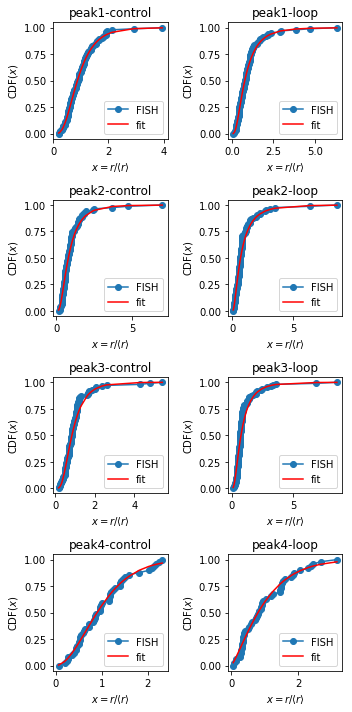

In [42]:
# PLOT THE CONTACT SHEET FOR ALL PAIRS
pdf_model = Model(PDF)

fig, ax = plt.subplots(4,2,figsize=(5,10))
# peak1-control
fitx = np.linspace(0.0, peak1_control_normed_sorted.max(),1000)
ax[0,0].plot(peak1_control_normed_sorted, peak1_control_normed_cdf,marker='o',label='FISH')
ax[0,0].plot(peak1_control_normed_sorted, fit_result_peak1_normed_control.best_fit,c='r',label='fit')

ax[0,0].set_xlabel(r'$x=r/\langle r\rangle$')
ax[0,0].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[0,0].legend(loc='lower right')
ax[0,0].set_title('peak1-control')

# peak1-loop
fitx = np.linspace(0.0, peak1_loop_normed_sorted.max(),1000)
ax[0,1].plot(peak1_loop_normed_sorted, peak1_loop_normed_cdf,marker='o',label='FISH')
ax[0,1].plot(peak1_loop_normed_sorted, fit_result_peak1_normed_loop.best_fit,c='r',label='fit')

ax[0,1].set_xlabel(r'$x=r/\langle r\rangle$')
ax[0,1].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[0,1].legend(loc='lower right')
ax[0,1].set_title('peak1-loop')

# peak2-control
fitx = np.linspace(0.0, peak2_control_normed_sorted.max(),1000)
ax[1,0].plot(peak2_control_normed_sorted, peak2_control_normed_cdf,marker='o',label='FISH')
ax[1,0].plot(peak2_control_normed_sorted, fit_result_peak2_normed_control.best_fit,c='r',label='fit')

ax[1,0].set_xlabel(r'$x=r/\langle r\rangle$')
ax[1,0].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[1,0].legend(loc='lower right')
ax[1,0].set_title('peak2-control')

# peak2-loop
fitx = np.linspace(0.0, peak2_loop_normed_sorted.max(),1000)
ax[1,1].plot(peak2_loop_normed_sorted,peak2_loop_normed_cdf,marker='o',label='FISH')
ax[1,1].plot(peak2_loop_normed_sorted, fit_result_peak2_normed_loop.best_fit,c='r',label='fit')

ax[1,1].set_xlabel(r'$x=r/\langle r\rangle$')
ax[1,1].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[1,1].legend(loc='lower right')
ax[1,1].set_title('peak2-loop')

# peak3-control
fitx = np.linspace(0.0, peak3_control_normed_sorted.max(),1000)
ax[2,0].plot(peak3_control_normed_sorted, peak3_control_normed_cdf,marker='o',label='FISH')
ax[2,0].plot(peak3_control_normed_sorted, fit_result_peak3_normed_control.best_fit,c='r',label='fit')

ax[2,0].set_xlabel(r'$x=r/\langle r\rangle$')
ax[2,0].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[2,0].legend(loc='lower right')
ax[2,0].set_title('peak3-control')

# peak3-loop
fitx = np.linspace(0.0, peak3_loop_normed_sorted.max(),1000)
ax[2,1].plot(peak3_loop_normed_sorted, peak3_loop_normed_cdf,marker='o',label='FISH')
ax[2,1].plot(peak3_loop_normed_sorted, fit_result_peak3_normed_loop.best_fit,c='r',label='fit')

ax[2,1].set_xlabel(r'$x=r/\langle r\rangle$')
ax[2,1].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[2,1].legend(loc='lower right')
ax[2,1].set_title('peak3-loop')

# peak4-control
fitx = np.linspace(0.0, peak4_control_normed_sorted.max(),1000)
ax[3,0].plot(peak4_control_normed_sorted, peak4_control_normed_cdf,marker='o',label='FISH')
ax[3,0].plot(peak4_control_normed_sorted, fit_result_peak4_normed_control.best_fit,c='r',label='fit')

ax[3,0].set_xlabel(r'$x=r/\langle r\rangle$')
ax[3,0].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[3,0].legend(loc='lower right')
ax[3,0].set_title('peak4-control')

# peak4-loop
fitx = np.linspace(0.0, peak4_loop_normed_sorted.max(),1000)
ax[3,1].plot(peak4_loop_normed_sorted, peak4_loop_normed_cdf,marker='o',label='FISH')
ax[3,1].plot(peak4_loop_normed_sorted, fit_result_peak4_normed_loop.best_fit,c='r',label='fit')

ax[3,1].set_xlabel(r'$x=r/\langle r\rangle$')
ax[3,1].set_ylabel(r'$\mathrm{CDF(}x\mathrm{)}$')

ax[3,1].legend(loc='lower right')
ax[3,1].set_title('peak4-loop')

plt.tight_layout()
#plt.savefig('/Users/guang/Dropbox/proj_grmc/output/figures/FISH_CDF_PDF_CONTACT_SHEET_HOMO.pdf', dpi = 300)
plt.show()

# Data from Finn EH et al, Cell, 2019.

# Data from Finn EH et al, Cell, 2019

## Data preparation

In this study, we use the data from [2] to illustrate our generalized method to extract distribution subpopulation. In this section, we first prepare our data. The raw FISH data [2] is obtained from the 4DN repository Dropbox depository https://data.4dnucleome.org/publications/80007b23-7748-4492-9e49-c38400acbe60/

**Instructions**:

* Download the all data files of "loci distances" type from https://data.4dnucleome.org/browse/?award.project=4DN&experimentset_type=replicate&type=ExperimentSetReplicate&publications_of_set.uuid=80007b23-7748-4492-9e49-c38400acbe60. We won't prepare data with this notebook since the size of all data combined is around 100Mbps.

* Run the codes in the cell below. *NOTE: please modify the first line of the code shown below to include the path which you saved the data files to.*

In [21]:
# load and read data files
# note that in this example, we save all the data files in the folder named "Misteli_2019". Please modify the code accordingly 
raw_files = glob.glob('../../../data/Misteli_2019/4DN*.txt')

all_data = []
for fp in raw_files:
    data = pd.read_csv(fp)
    all_data.append(data)
all_data_df = pd.concat(all_data, ignore_index=True)

# CLEAN UP THE DATA
# There are some probes should not be used. Locations: Chr1-61560943, Chr17-30541949, Chr18-40596626
cond1 = all_data_df['Bait Start'] != 61560943
cond2 = all_data_df['Bait Start'] != 30541949
cond3 = all_data_df['Bait Start'] != 40596626
cond4 = all_data_df['Target Start'] != 61560943
cond5 = all_data_df['Target Start'] != 30541949
cond6 = all_data_df['Target Start'] != 40596626

all_data_df = all_data_df[cond1 & cond2 & cond3 & cond4 & cond5 & cond6]
all_data_df = all_data_df.reset_index(drop=True)

# THERE ARE SOME PAIRS WHERE BAIT IS AS THE SAME AS TARGET
all_data_df = all_data_df[all_data_df['Bait Start'] != all_data_df['Target Start']]
all_data_df = all_data_df.reset_index(drop=True)

grouped = all_data_df.groupby(['Bait Chr','Bait Start','Bait End','Target Chr','Target Start','Target End'])

# NOTE THAT BAIT AND TARGET CAN BE EXCHANGED
# WE NEED TO COMBINE (BAIT, TARGET) AND (TARGET, BAIT) TO THE SAME GROUP

duplicate_keys = []
for key, values in grouped.groups.items():
    #print(key)
    key_reverse = (key[0],key[4],key[5],key[3],key[1],key[2])
    if key_reverse in grouped.groups:
        if [key_reverse, key] not in duplicate_keys:
            duplicate_keys.append([key, key_reverse])

# Combine the same pairs together and extract data
pairs = []
genomic_distance_all = []
distance_all = []
for key, value in grouped.groups.items():
    key_reverse = (key[0],key[4],key[5],key[3],key[1],key[2])
    if [key, key_reverse] in duplicate_keys:
        value_2 = grouped.groups[key_reverse]
        temp1 = all_data_df.iloc[value]['SpotDist.3D'].values
        temp2 = all_data_df.iloc[value_2]['SpotDist.3D'].values
        distance_all.append(np.concatenate((temp1, temp2)))   

        genomic_end = np.unique((all_data_df.iloc[value]['Target End'] + all_data_df.iloc[value]['Target Start'])/2.0)
        genomic_start = np.unique((all_data_df.iloc[value]['Bait End'] + all_data_df.iloc[value]['Bait Start'])/2.0)
        
        genomic_distance_temp = np.abs(genomic_end - genomic_start)
        genomic_distance_all.append(genomic_distance_temp)
        pairs.append(key)
    elif [key_reverse, key] in duplicate_keys:
        continue
    else:
        temp = all_data_df.iloc[value]['SpotDist.3D'].values
        distance_all.append(temp)
    
        genomic_end = np.unique((all_data_df.iloc[value]['Target End'] + all_data_df.iloc[value]['Target Start'])/2.0)
        genomic_start = np.unique((all_data_df.iloc[value]['Bait End'] + all_data_df.iloc[value]['Bait Start'])/2.0)

        genomic_distance_temp = np.abs(genomic_end - genomic_start)
        genomic_distance_all.append(genomic_distance_temp)
        pairs.append(key)

# genomic_distance_all contains the genomic distance for every pair
genomic_distance_all = np.array(genomic_distance_all).flatten()
# pairs contains the tuple of each pair
pairs = np.array(pairs)
# distance_all contains the distance measurements for each pair
distance_all = np.array(distance_all)

# save the clean data into a new dataframe
try:
    del new_array
except NameError:
    pass

for idx in range(len(pairs)):
    length = len(distance_all[idx])
    temp1 = np.repeat([pairs[idx]], length, axis=0)
    temp2 = np.repeat([genomic_distance_all[idx]], length, axis=0).reshape(-1,1)
    temp4 = np.hstack((temp1, temp2, distance_all[idx].reshape(-1,1)))
    try:
        new_array = np.vstack((new_array, temp4))
    except NameError:
        new_array = np.copy(temp4)
        
clean_data_df = pd.DataFrame(new_array, columns=['Bait Chr','Bait Start','Bait End','Target Chr','Target Start','Target End','Genomic Distance','Spatial Distance'])

# group the clean data frame according to pair information
clean_grouped = clean_data_df.groupby(['Bait Chr','Bait Start','Bait End','Target Chr','Target Start','Target End'])

After the data is collected and cleaned. We need to define some functions.

* We need to define a function to compute empirical cumulative distribution function from the data.
* We need to define a function to perform non-negative Tikhonov regularization described in the Supplementary Information Note 8
* We need to define a function to find the optimal value of parameter $\alpha$ (appears in the Tikhonov regularization, see the Supplementary Information Note 8 for more details) and output the solution for $P(\langle R\rangle)$.

In [14]:
# Define function to compute empirical CDF from the data
def compute_cdf_from_data_duplicate(data, norm_by_mean=False):
    data_unique, counts = np.unique(data, return_counts = True)
    
    if norm_by_mean:
        data_unique = data_unique/np.mean(data)
    
    data_cdf = np.cumsum(counts)/np.sum(counts)
    #data_cdf = np.linspace(0.0,1.0, len(data_sorted))
    return data_unique, data_cdf

# Define function to perform non-negative Tikhonov (Ridge) regularization
def NN_Ridge(A, b, alpha=1.0):
    A_nn = np.vstack((A, alpha*np.identity(A.shape[1])))
    b_nn = np.hstack((b, np.zeros(A.shape[1])))
    x, residue = scipy.optimize.nnls(A_nn, b_nn)
    return x, residue

# Define function to compute the distribution of subpopulations using non-negative Tikhonov regularization
def GETFIT(data):
    x, y = compute_cdf_from_data_duplicate(data, norm_by_mean=False)
    r = np.copy(x)
    f = np.copy(y)
    rmean = np.linspace(0.001,15.0,1000)
    k_temp = CDF(r[:, None], rmean[None, :], 1.0, 5.0/4.0)

    Lcurve = []
    alpha_min = 0.1
    alpha_max = 2.0
    alpha_list = np.logspace(np.log10(alpha_min),np.log10(alpha_max),30)
    for alpha in alpha_list:
        sol, residue = NN_Ridge(k_temp, f, alpha=alpha)
        Lcurve.append([np.sqrt(np.sum(np.power(f- np.dot(k_temp, sol),2.0))),\
                       np.sqrt(np.sum(np.power(sol, 2.0)))])

    Lcurve = np.array(Lcurve)

    f1 = interp1d(alpha_list, Lcurve[:,0], kind='cubic')
    f2 = interp1d(alpha_list, Lcurve[:,1], kind='cubic')

    xnew = np.logspace(np.log10(alpha_min),np.log10(alpha_max),1000)
    ynew1 = f1(xnew)
    ynew2 = f2(xnew)

    dx = np.gradient(ynew1, xnew)
    dy = np.gradient(ynew2, xnew)
    ddx = np.gradient(dx, xnew)
    ddy = np.gradient(dy, xnew)

    curvature = np.abs(dx * ddy - ddx * dy)/\
    np.power(np.power(dx,2.0)+np.power(dy,2.0),1.5)

    alpha_optimal = xnew[curvature.argmax()]

    sol, residue = NN_Ridge(k_temp, f, alpha=alpha_optimal)
    return x, y, sol, residue, k_temp, rmean, alpha_optimal

## Fig.5 in the main text

Here we demonstrate how to generate the figures shown in Fig.5 in the main text. The following code performs 1) extract distances data from our dataframe 2) perform non-negative Tikhonov regularization to solve for $P(\langle R\rangle)$. Note here we only show the figure for one particular pair. One can modify the variable `bait_chr`, `bait_start`, `bait_end`, `target_chr`, `target_start` and `target_end` to specify the pair

In [26]:
# extract the distance data of a specific pair from dataframe
# Note that (17.0,38743489.0,38939529.0,17.0,65509811.0,65678200.0)

bait_chr = 17
target_chr = 17
bait_start = 38743489
bait_end = 38939529
target_start = 65509811
target_end = 65678200

distance_array = clean_data_df.iloc[clean_grouped.groups\
                                    [(bait_chr,bait_start,bait_end,target_chr,target_start,target_end)]]\
                                    ['Spatial Distance'].values

# Solve for P(\langle R\rangle) from the data using the non-negative Tikhonov regularization
x, y, sol, residue, k_temp, rmean, alpha_optimal = GETFIT(distance_array)

# print out the optimal value of paramter \alpha in the Tikhonov regularization
print('Optimal Alpha Value:', alpha_optimal)

Optimal Alpha Value: 0.6774668128944609


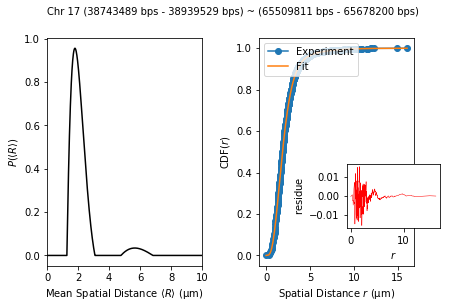

In [27]:
# Plot the P(\langle R\rangle) as well as the fitted CDF

fig, ax = plt.subplots(1,2)
ax[0].plot(rmean[:-1], sol[:-1]/(rmean[1:]-rmean[:-1]),c='k')
ax[0].set_xlim([0.0,10.0])
ax[1].step(x, y, label='Experiment', marker='o')
ax[1].plot(x, np.dot(k_temp, sol)*(1.0/np.max(np.dot(k_temp, sol))), c='#ff7f0e', label='Fit')
ax[1].legend(loc='upper left')

axins = inset_axes(ax[1], width=1.3, height=0.9, bbox_to_anchor=(.9, .1, .3, .37),bbox_transform=ax[1].transAxes)
axins.plot(x, np.dot(k_temp, sol)*(1.0/np.max(np.dot(k_temp, sol))) - y,c='r',linewidth=0.5)
axins.set_xlabel(r'$r$')
axins.set_ylabel(r'$\mathrm{residue}$')


ax[0].set_xlabel(r'$\mathrm{Mean\ Spatial\ Distance\ }\langle R\rangle \ (\mathrm{\mu m})$')
ax[0].set_ylabel(r'$P(\langle R\rangle)$')
ax[1].set_ylabel(r'$\mathrm{CDF}(r)$')
ax[1].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\ (\mathrm{\mu m})$')
plt.text(0.0,1.1, 'Chr 17 (38743489 bps - 38939529 bps) ~ (65509811 bps - 65678200 bps)',transform=ax[0].transAxes)
plt.tight_layout()
plt.show()

## Fig.6 in the main text

Here we demonstrate how to generate Fig.6 in the main text. Note that the following codes runs about half to one hour on a 8-cores machine. We provide the results in an `.npy` in this folder.

In [ ]:
# Loop over all the pairs, perform non-negative Tikhonov regularization for each pair and save the results
pr = []
kstest = []
rmsd = []
alpha_all = []
for idx, item in enumerate(distance_all):
    x, y, sol, residue, k_temp, rmean, alpha_optimal = GETFIT(item)
    
    alpha_all.append(alpha_optimal)
    pr.append(np.array(list(zip(rmean[:-1], sol[:-1]/(rmean[1:] - rmean[:-1])))))
    rmsd_temp = np.sqrt(np.mean(np.power(np.dot(k_temp, sol)*(1.0/np.max(np.dot(k_temp, sol))) - y, 2.0)))
    rmsd.append(rmsd_temp)

In [29]:
# You can load the pre-computed results here
# pr = np.load('../../../output/data/Misteli_analysis/Misteli_pr_all_pairs.npy')

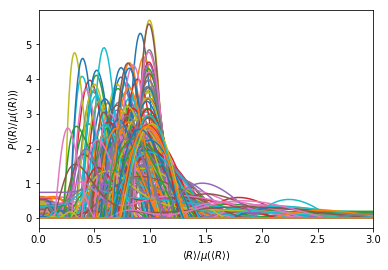

In [31]:
# Plot the Fig.6(a)
fig, ax = plt.subplots()
for idx, item in enumerate(pr):
    norm = 1.0/np.sum(item[:,1]*0.01501401)
    mean = np.sum(item[:,0] * norm * item[:,1] * 0.01501401)
    ax.plot(item[:,0]/mean, item[:,1] * mean, alpha=1.0)
ax.set_xlim([0.0,3.0])
ax.set_xlabel(r'$\langle R\rangle/\mu(\langle R\rangle)$')
ax.set_ylabel(r'$P(\langle R\rangle/\mu(\langle R\rangle))$')
plt.show()

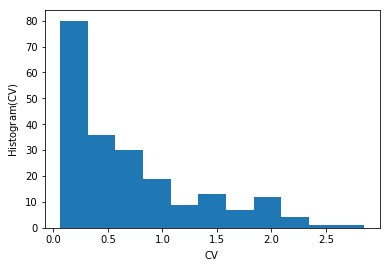

In [32]:
# compute variation coefficients
vc = []
for item in pr:
    norm = 1.0/np.sum(item[:,1]*0.015014014014014015)
    mean = np.sum(item[:,0] * norm * item[:,1] * 0.015014014014014015)
    meansquare = np.sum(np.power(item[:,0],2.0) * norm * item[:,1] * 0.015014014014014015)
    std = np.sqrt(meansquare - mean**2.0)
    vc.append(std/mean)
vc = np.array(vc)

# plot the Fig.6(b) in the main text
fig, ax = plt.subplots()
ax.hist(vc,bins='auto')
ax.set_xlabel(r'$\mathrm{CV}$')
ax.set_ylabel(r'$\mathrm{Histogram(CV)}$')
plt.show()

## Fig. 8 in the Supplementary Information

In [ ]:
for i in range(15):
    fig, ax = plt.subplots(5,6,figsize=(10.0,10.0/1.29))
    for j in range(15):
        idx = i*15+j
        if idx > 211:
            break
            
        norm = 1.0/np.sum(pr[idx][:,1]*0.015014014014014015)
        mean = np.sum(pr[idx][:,0] * norm * pr[idx][:,1] * 0.015014014014014015)

        ax[(2*j)//6, (2*j)%6].plot(pr[idx][:,0], pr[idx][:,1], c='k')
        ax[(2*j)//6, (2*j)%6].set_xlim([0.0,3.0*mean])
        ax[(2*j+1)//6, (2*j+1)%6].step(CDF_EXP[idx][:,0], CDF_EXP[idx][:,1], label='Experiment', marker='o')
        ax[(2*j+1)//6, (2*j+1)%6].plot(CDF_FIT[idx][:,0], CDF_FIT[idx][:,1], c='#ff7f0e', label='Fit')

        ax[(2*j)//6, (2*j)%6].set_xlabel(r'$\mathrm{Mean\ Spatial\ Distance\ }\langle R\rangle \ (\mathrm{\mu m})$',\
                                        fontsize=5)
        ax[(2*j)//6, (2*j)%6].set_ylabel(r'$P(\langle R\rangle)$',\
                                        fontsize=5)
        ax[(2*j+1)//6, (2*j+1)%6].set_ylabel(r'$\mathrm{CDF}(r)$',\
                                            fontsize=5)
        ax[(2*j+1)//6, (2*j+1)%6].set_xlabel(r'$\mathrm{Spatial\ Distance\ }r\ (\mathrm{\mu m})$',\
                                            fontsize=5)
        fig.text(0.0,1.1, 'Chr {} ({} bps - {} bps) ~ ({} bps - {} bps)'.\
                 format(pairs[idx][0], pairs[idx][1], pairs[idx][2],\
                       pairs[idx][4], pairs[idx][5])\
                 ,transform=ax[(2*j)//6, (2*j)%6].transAxes,fontsize=5)

    fig.tight_layout()
    plt.show()

# References

* Rao, Suhas SP, et al. "A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping." Cell 159.7 (2014): 1665-1680.

* Finn, Elizabeth H., et al. "Extensive Heterogeneity and Intrinsic Variation in Spatial Genome Organization." Cell 176.6 (2019): 1502-1515.